# **Before you start**

*   Go to "*File*" --> "*Save a copy in Drive*"
*   Open that copy (might open automatically)
*   Then continue below

---
---
---

# Machine Listening Seminar 3: Sound event classification

What we are going to do:
* Implement a full processing pipeline for sound event classification
* Use a traditional classification technique (and compare with deep-learning based methods later).

---

# 1. Import libraries

* We need a number of libraries. Import them once to use throughout the document.

In [1]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

---

# 2. Fetch the Dataset

*   ESC-50: a dataset for Environmental Sound Classification (https://github.com/karolpiczak/ESC-50, https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)
 * 50 classes,  40 files per class, 5s clips
*   Download & unzip the dataset running the cell below. This will take a minute. You will see the new files on the left (folder icon).

In [2]:
!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
!unzip master.zip

--2023-11-30 10:02:46--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2023-11-30 10:02:46--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [            <=>     ] 615.78M  14.6MB/s    in 40s     

2023-11-30 10:03:27 (15.4 MB/s) - ‘master.zip’ saved [645695005]

Archive:  master.zip
33c8ce9eb2cf0b1c2f8bcf322eb349b6be34dbb6
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-

---

# 3. Metadata and analysis I

***Tasks:***
* Use pandas to read the csv file in *ESC-50-master/meta/*
* Print the first elements of the csv. Pandas has a standard function for this.
* Print the list of *unique* class labels in the dataset, and check whether there really are 50 of them

In [3]:
fn_csv = 'ESC-50-master/meta/esc50.csv'


### START CODING
df = pd.read_csv(fn_csv)  # pd = pandas dataframe
toplist = df.head()
print(toplist)

unique_classes = df['category'].unique()  # you may use unique()
print(f'Unique classes: {unique_classes}\nCount: {len(unique_classes)}')
### END CODING

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
Unique classes: ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'r

Expected output:
```
    filename            fold  target  category        esc10   src_file  take
0   1-100032-A-0.wav    1     0       dog             True    100032    A
1   1-100038-A-14.wav   1     14      chirping_birds  False   100038    A
2   1-100210-A-36.wav   1     36      vacuum_cleaner  False   100210    A
3   1-100210-B-36.wav   1     36      vacuum_cleaner  False   100210    B
4   1-101296-A-19.wav   1     19      thunderstorm    False   101296    A
```

```
Unique classes: ['dog' 'chirping_birds' ... ]
Count: 50
```


---

# 4. Metadata and analysis II

* View and listen to some examples in the dataset to get a "feeling" for the sound classes.

vacuum_cleaner


vacuum_cleaner
thunderstorm


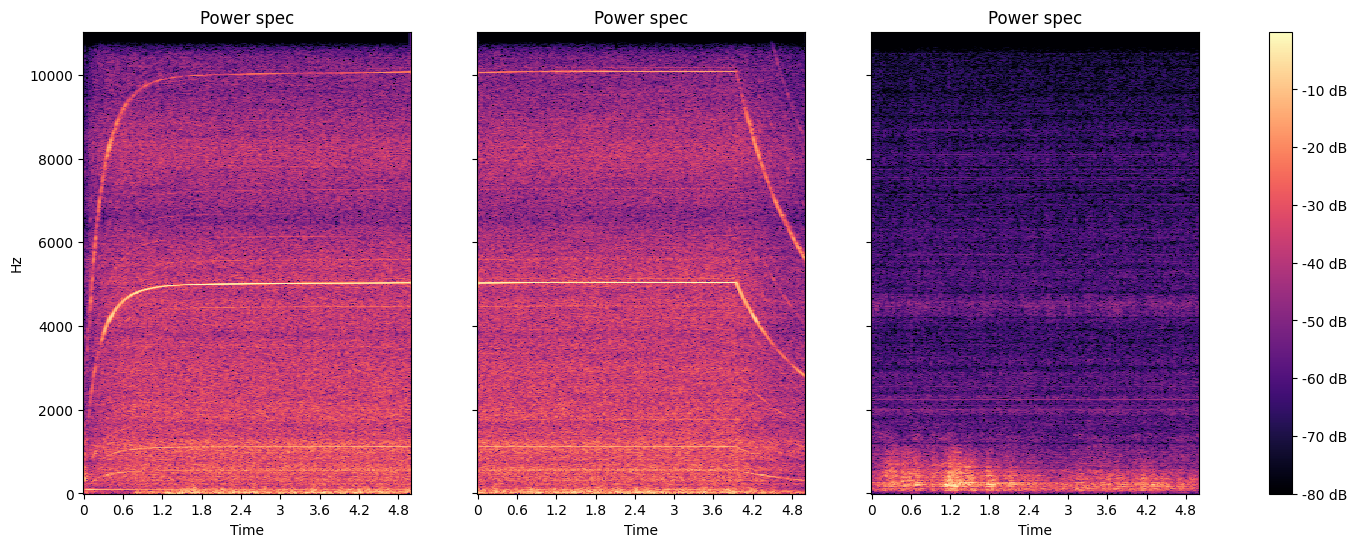

In [4]:
# Setup some filepaths
path = 'ESC-50-master/audio/'
file0 = path + df['filename'][2]  # We use indices [2-4] here, feel free to choose other files
file1 = path + df['filename'][3]
file2 = path + df['filename'][4]

# Show audio player for each file
print(df['category'][2])
IPython.display.display(IPython.display.Audio(data=file0))
print(df['category'][3])
IPython.display.display(IPython.display.Audio(data=file1))
print(df['category'][4])
IPython.display.display(IPython.display.Audio(data=file2))

# Plot mel specs
files = [file0, file1, file2]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i in range(3):
  y, sr = librosa.load(files[i])
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
  img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax[i])
  ax[i].set(title='Power spec')
  ax[i].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

---

# 5. ESC-5: Curation

Let's select 5 classes (*our_classes*) from ESC-50 to make things a bit faster.

***Tasks:***
* Collect all files that belong to *our_classes*.
* Put the files and their respective classes in separate lists. Make sure their indices are equal (meaning: the value at index 3 of list *A* is related to the value at index 3 of list *B*).
  * Idea 1: Use *df.values* to iterate over the rows of the csv
  * Idea 2: Use *df.query('category in @our_classes')*
* Print the first 5 elements of each list as (file, class)-tuples. Also, print the overall lengths of the lists.

In [5]:
our_classes = ['crying_baby', 'dog', 'rain', 'rooster', 'sneezing']  # Note: This is also a class map for later.
esc5_X = []  # File list
esc5_y = []  # Class list
fn_csv = 'ESC-50-master/meta/esc50.csv'


### START CODING ###
df = pd.read_csv(fn_csv)

for row in df.values:  # This is one way, not an ideal way: This loop aims to find files for each class in our_classes.
  if any(cls == row[3] for cls in our_classes):
    esc5_X.append( row[0] )  # filename column of df
    esc5_y.append( row[3] )  # class column of df

print( list(zip(esc5_X[:5], esc5_y[:5])) )
print('Lengths: esc5_X: {}, esc5_y: {}'.format( len(esc5_X), len(esc5_y) ))
### END CODING ###

[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-17367-A-10.wav', 'rain'), ('1-187207-A-20.wav', 'crying_baby'), ('1-211527-A-20.wav', 'crying_baby')]
Lengths: esc5_X: 200, esc5_y: 200


Expected output:
```
[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-17367-A-10.wav', 'rain'), ('1-187207-A-20.wav', 'crying_baby'), ('1-211527-A-20.wav', 'crying_baby')]
Lengths: esc5_X: 200, esc5_y: 200
```



---

# 6. ESC-5: Dataset splitting

***Tasks:***
* Split the dataset into *train* and *test* subsets: split ratio is 80%/20%, and random state 1337.
  * Use a suitable straight-forward function from sklearn.
* Print the first 3 elements of the resulting *X_train*.
* Print the overall lengths of the resulting lists. Are they aligned with the ratio?

Result: ESC-5 is ready. We have a train and test set consisting of file lists and their respective classes.

In [6]:
### START CODING HERE ###
X_train, X_test, y_train, y_test = train_test_split(esc5_X, esc5_y, test_size=0.2, random_state=1337)

print(X_train[:3])
print(f'X: {len(X_train)}, {len(X_test)}; y: {len(y_train)}, {len(y_test)}')
### END CODING ###

['5-203128-A-0.wav', '4-181286-A-10.wav', '3-157615-A-10.wav']
X: 160, 40; y: 160, 40


Expected output:
```
['5-203128-A-0.wav', '4-181286-A-10.wav', '3-157615-A-10.wav']
X: 160, 40; y: 160, 40
```

---
# 7. ESC-5: Create mel spectrograms

We need to compute features and corresponding labels for each file in our ESC-5.

***Tasks:***
* Define a function that does the following (in this order!):
  * takes input parameters: *X_train* (list of filenames), *y_train* (list of classes)
  * loops over *X_train* (hint: *enumerate* it), and loads each file (.wav) using librosa
  * creates the mel spectrogram from the loaded .wav samples
  * normalizes the mel spec by dividing it through the number of given *mel_bands*.
  * transposes the mel spec
  * appends the features (mel spec) to a feature tensor
  * creates a target vector consisting of as many values as there are frames
    * hint: use .shape to see which value you need
  * each value inside the vector must correspond to the index of the class in *our_classes*
    * hint: remember *numpy.ones(...)* ?
    * hint: use *.index(...)* here. Not ideal, but works here.
  * appends the targets to a target tensor
  * stacks the large feature and target lists appropriately
  * returns the tensors
* Finally, print the shapes of all 4 arrays.

In [7]:
### START CODING HERE ###
def extract_mel_spec(data_X, data_y):
  X = []  # feature tensor
  y = []  # target tensor

  mel_bands = 128
  for i, filename in tqdm(enumerate(data_X)):  # tqdm simply displays a progress bar.
    wav_data, sr = librosa.load(f'ESC-50-master/audio/{filename}')  # Use the wav file's sample rate.

    # Features (2D)
    mel_spec = librosa.feature.melspectrogram(y=wav_data, sr=sr, n_mels=mel_bands)  # Create mel spectrogram. Output shape: (128, 216) (n_mels, frames)
    mel_spec = mel_spec/mel_bands  # Normalization
    mel_spec = mel_spec.T  # Transposition. Output shape: (216, 128)
    X.append( mel_spec )  # Append to feature tensor

    # Targets == class_name
    targets = np.ones( mel_spec.shape[0] )  # Create a PLACEHOLDER target vector. Output shape: (216) (Note: silent frames are not going to be labeled as "silent")
    targets = targets * our_classes.index( data_y[i] )  # Convert values to actual class-index from 'our_classes'
    y.append( targets )  # Append to target tensor

  # Stack tensors
  X = np.vstack(X)
  y = np.hstack(y)

  # Return the tensors
  return X, y


# Call the function on our previously generated lists
X_train_ready, y_train_ready = extract_mel_spec(X_train, y_train)
X_test_ready, y_test_ready = extract_mel_spec(X_test, y_test)
### END CODING HERE ###


print(f'\nShapes: X_train_ready: {X_train_ready.shape}, y_train_ready: {y_train_ready.shape}')
print(f'Shapes: X_test_ready: {X_test_ready.shape}, y_test_ready: {y_test_ready.shape}')

160it [00:02, 55.47it/s]
40it [00:00, 80.89it/s]


Shapes: X_train_ready: (34560, 128), y_train_ready: (34560,)
Shapes: X_test_ready: (8640, 128), y_test_ready: (8640,)


Expected output:
```
Shapes: X_train_ready: (34560, 128), y_train_ready: (34560,)
Shapes: X_test_ready: (8640, 128), y_test_ready: (8640,)
```



---

# 8. ESC-5: Train a nearest neighbor classifier

***Tasks:***
* Standardize the features from step 7 using sklearn.
* Use the features and targets to train (*fit*) a kNN-classifier from sklearn, with 5 neighbors and uniform weighting.
* Print the scores on the train set and test set, rounded to 4 decimals. (This will take some time!)


In [15]:
### START CODING HERE ###
# Feature scaling / Data standardization / Normalization
print('Scaling...')
scaler = StandardScaler()
scaler.fit(X_train_ready)
X_train_ready = scaler.transform(X_train_ready)  # Normalize the features here for both train and test
X_test_ready = scaler.transform(X_test_ready)

print('Fitting...')
model = KNeighborsClassifier(n_neighbors=5, weights='uniform')  # Call the kNN-classifier. Look at your imports again for a hint.
model.fit(X_train_ready, y_train_ready)  # Fit/Train the classifier using our generated tensors.

print('Evaluating...')
print(f'Train score: {np.round(model.score(X_train_ready, y_train_ready), decimals=4)}')
print(f'Test score: {np.round(model.score(X_test_ready, y_test_ready), decimals=4)}')
### END CODING HERE ###

Scaling...
Fitting...
Evaluating...
Train score: 0.7655
Test score: 0.5769


Expected output (might differ slightly):
```
Train score: 0.7624
Test score: 0.5812
```



---

# 9. ESC-5: Plot the confusion matrix
We want to learn more about our classifier. How well does it perform per class?

***Tasks:***
* Using scikit-learn, create a confusion matrix of our classifier over the test set
* Normalize the rows, use 'our_classes' as axes tick values
* Display the plot

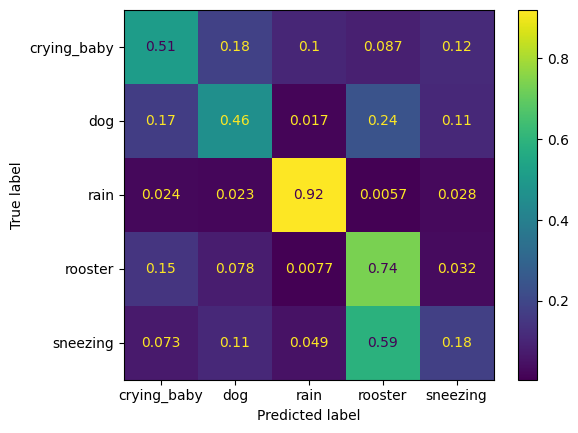

In [21]:
### START CODING HERE ###
y_test_pred = model.predict(X_test_ready)
cm = confusion_matrix(y_test_ready, y_test_pred, normalize='true')  # Call the confusion matrix plot function. Look at your imports again for a hint.
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.xticks(ticks=np.arange(5), labels=our_classes)  # hint: np.arange(5) = (0, 1, 2, 3, 4)
plt.yticks(ticks=np.arange(5), labels=our_classes)
plt.show()
### END CODING HERE ###

Expected output:

* a coloured confusion matrix
* each row should add up to 1
* labels from *our_classes* on x-axis and y-axis
* similar to this:


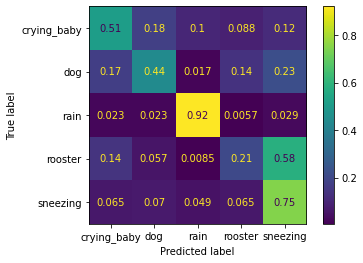